In [1]:
import config
from exp_agents.microscopy_agent_local import LocalMicroscopyAnalysisAgent as AnalysisAgent
from exp_agents.instruct import DIFFRACTION_ANALYSIS_INSTRUCTIONS
import matplotlib.pyplot as plt

In [9]:
def resample_image(I, x, y, qx, qy):
    from scipy.interpolate import RectBivariateSpline
    import numpy as np
    interpolator = RectBivariateSpline(x, y, I)
    qxg, qyg = np.meshgrid(qx, qy, indexing='ij')
    return interpolator.ev(qxg.ravel(), qyg.ravel()).reshape(qxg.shape)
    
def calc_diffration_pattern(cif_string, zone_axis):

    import ase
    from ase.io import read
    from ase.build import surface
    from io import StringIO
    import abtem
    import numpy as np
    '''
    parameters
    '''
    semiangle = 0.5
    energy = 200e3
    frq_limit = 1 #A^-1
    plane = zone_axis
    
    abtem.config.set({"device": "gpu", "fft": "fftw"})
    atoms = read(StringIO(cif_string), format='cif')
    atoms.set_pbc([True, True, True])  # ensure it's treated as a bulk lattice
    #abtem.show_atoms(atoms, plane="xy", legend=True);
    surface_atoms = surface(atoms, plane, layers=3, periodic=True)
    surface_atoms_repeated = surface_atoms * (10, 10, 10)
    
    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    #abtem.show_atoms(surface_atoms_repeated , ax=ax1, plane="xy", title="Beam view")
    #abtem.show_atoms(surface_atoms_repeated , ax=ax2, plane="yz", title="Side view", linewidth=0);
    frozen_phonons = abtem.FrozenPhonons(surface_atoms_repeated, 8, sigmas=0.1)
    potential = abtem.Potential(
        frozen_phonons,
        gpts=512,
        projection="infinite",
    )
    wave = abtem.Probe(energy=energy, semiangle_cutoff=semiangle)
    exit_waves = wave.multislice(potential)
    measurement_ensemble = exit_waves.diffraction_patterns(max_angle=30,block_direct = True)
    measurement = measurement_ensemble.mean(0)
    measurement.compute()
    I = measurement.array.get()
    x_rep = measurement.axes_metadata[0].coordinates(I.shape[0])
    y_rep = measurement.axes_metadata[1].coordinates(I.shape[1])
    qp = np.arange(-frq_limit,frq_limit,0.01) 
    I = resample_image(I, x_rep, y_rep, qp, qp)
    return I

def convert_miller_direction(index):
    """
    Convert 4-index Miller-Bravais direction [u, v, t, w] to 3-index [u, v, w].
    If already 3-index, return unchanged.

    Parameters:
        index (tuple): A tuple of length 3 or 4 representing a crystallographic direction.

    Returns:
        tuple: A 3-index direction.
    """
    if len(index) == 3:
        return index
    elif len(index) == 4:
        u, v, t, w = index
        if t != -(u + v):
            raise ValueError(f"Invalid 4-index direction: expected t = -(u + v), got {t} != {-(u + v)}")
        return (u, v, w)
    else:
        raise ValueError(f"Expected 3 or 4 indices, got {len(index)}: {index}")

In [3]:
analysis_agent = AnalysisAgent(model_name=config.ANALYSIS_AGENT_MODEL, fft_nmf_settings=config.FFT_NMF_SETTINGS)
result_json = analysis_agent._analyze_diffraction_base(config.IMAGE_PATH, system_info=config.SYSTEM_INFO, instruction_prompt = DIFFRACTION_ANALYSIS_INSTRUCTIONS)

Loading checkpoint shards:   0%|          | 0/11 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Image resized from 384x383 to 256x255 to fit model context window


/home/yaol750/.local/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/yaol750/.local/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `64` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Gemma3 output: 
```json
[
  {
    "crystal_geometry": {
      "bravais_lattice": "face-centered cubic",
      "zone_axis": "[111]"
    },
    "possible_phases": [
      {
        "phase_name": "Gold",
        "structure_type": "fcc Au",
        "confidence": 0.95,
        "justification": "The diffraction pattern exhibits a high symmetry with multiple spots arranged in a characteristic pattern for a face-centered cubic structure. The material is identified as gold nanoparticles, which crystallizes in the fcc structure.",
        "cif_description": "data_gold_fcc\n_audit_creation_method 'Generated manually'\n\n_symmetry_space_group_name_H-M 'Fm-3m'\n_symmetry_Int_Tables_number 225\n\n_cell_length_a 4.078\n_cell_length_b 4.078\n_cell_length_c 4.078\n_cell_angle_alpha 90\n_cell_angle_beta 90\n_cell_angle_gamma 90\n\nloop_\n_symmetry_equiv_pos_as_xyz\n'x, y, z'\n'x, y, -z'\n'x, -y, z'\n'x, -y, -z'\n'-x, y, z'\n'-x, y, -z'\n'-x, -y, z'\n'-x, -y, -z'\n'y, x, z'\n'y, x, -z'\n'y, -x, z'\n'y, -

Input:  
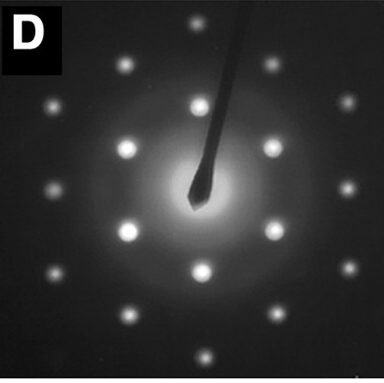  
{
    "material_type": "Au nanoparticle",  
    "synthesis_details": "We have also exploited the use of these silver nanocubes as sacrificial templates to generate gold nanoboxes with a well-defined shape and hollow structure.",  
    "microscopy_type": "Electron diffraction"
}  
Source: https://www.science.org/doi/full/10.1126/science.1077229  

[########################################] | 100% Completed | 606.93 ms
fcc Au (1, 1, 1), justification: The diffraction pattern exhibits a high symmetry with multiple spots arranged in a characteristic pattern for a face-centered cubic structure. The material is identified as gold nanoparticles, which crystallizes in the fcc structure.
[########################################] | 100% Completed | 707.05 ms
fcc Au (1, 0, 0), justification: While [111] is more common, [100] is also possible. The pattern shows a consistent symmetry, and the material is known to be gold.


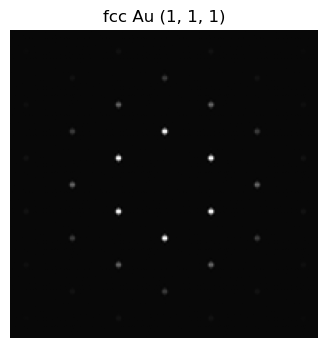

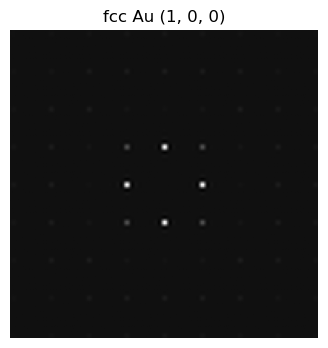

In [6]:
for json_i in result_json:
    crystal = json_i['crystal_geometry']
    zone_axis = crystal['zone_axis']
    zone_axis = tuple(int(ch) for ch in zone_axis.strip("[]"))
    phases = json_i['possible_phases']
    for phase in phases:
        cif_string = phase['cif_description']
        I = calc_diffration_pattern(cif_string, zone_axis)
        f,ax = plt.subplots(figsize = (4,4))
        ax.imshow(I,cmap = 'gray')
        ax.set_axis_off()
        ax.set_title(phase["structure_type"] + ' ' + str(zone_axis))
        print(phase["structure_type"] + ' ' + str(zone_axis) + ', justification: '+ phase['justification'])

In [3]:
analysis_agent = AnalysisAgent(model_name=config.ANALYSIS_AGENT_MODEL, fft_nmf_settings=config.FFT_NMF_SETTINGS)
result_json = analysis_agent._analyze_diffraction_base(config.IMAGE_PATH, system_info=config.SYSTEM_INFO, instruction_prompt = DIFFRACTION_ANALYSIS_INSTRUCTIONS)

Loading checkpoint shards:   0%|          | 0/11 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Image resized from 384x383 to 256x255 to fit model context window


/home/yaol750/.local/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/yaol750/.local/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `64` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Gemma3 output: 
```json
[
  {
    "crystal_geometry": {
      "bravais_lattice": "cubic",
      "zone_axis": "[100]"
    },
    "possible_phases": [
      {
        "phase_name": "Gold",
        "structure_type": "fcc Au",
        "confidence": 0.95,
        "justification": "The diffraction pattern shows a clear streak pattern consistent with a cubic crystal system. The presence of (100) and (200) reflections, along with the overall symmetry, strongly suggests a [100] zone axis of a face-centered cubic (fcc) structure. The material is known to be gold nanoparticles.",
        "cif_description": "data_gold_fcc\n_audit_creation_method 'Generated manually'\n\n_symmetry_space_group_name_H-M 'fcc'\n_symmetry_Int_Tables_number 1\n\n_cell_length_a 4.078\n_cell_length_b 4.078\n_cell_length_c 4.078\n_cell_angle_alpha 90\n_cell_angle_beta 90\n_cell_angle_gamma 90\n\nloop_\n_symmetry_equiv_pos_as_xyz\n'x, y, z'\n'x, y, -z'\n'x, -y, z'\n'x, -y, -z'\n'-x, y, z'\n'-x, y, -z'\n'-x, -y, z'\n'-x, -y, 

Input:  
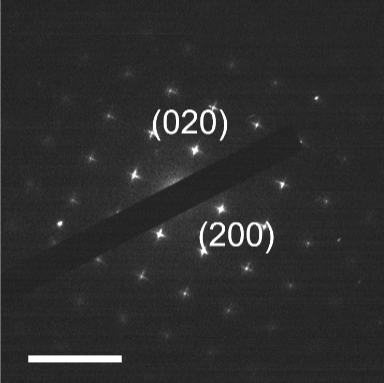  
System info:  
{
    "material_type": "Au nanoparticle",  
    "synthesis_details": "The gold concave nanocubes, nanocubes (i.e., regular cubes bounded with six {100} facets), and nanospheres were synthesized with our adaptions to universal seeded growth. The synthesis includes three steps: (i) preparation of gold nanorods, (ii) preparation of monodisperse spherical seeds from the gold nanorods by iterative etching and regrowth, and (iii) growth of the product nanoparticles from the monodisperse spherical seeds.",  
    "microscopy_type": "SAED",  
    "experimental_details": {
        "voltage": "200 kV"
    }
}  
Source: https://www.nature.com/articles/s41565-023-01355-w#Sec15

[###                                     ] | 9% Completed | 105.08 ms

/home/yaol750/anaconda3/envs/gemma3/lib/python3.12/site-packages/ase/spacegroup/spacegroup.py:481: UserWarning: scaled_positions 1 and 3 are equivalent
  warnings.warn(


[########################################] | 100% Completed | 1.62 sms
fcc Au (1, 0, 0), justification: The diffraction pattern shows a clear streak pattern consistent with a cubic crystal system. The presence of (100) and (200) reflections, along with the overall symmetry, strongly suggests a [100] zone axis of a face-centered cubic (fcc) structure. The material is known to be gold nanoparticles.


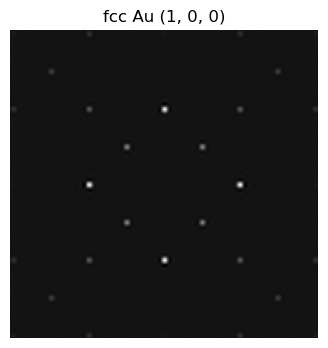

In [4]:
for json_i in result_json:
    crystal = json_i['crystal_geometry']
    zone_axis = crystal['zone_axis']
    zone_axis = tuple(int(ch) for ch in zone_axis.strip("[]"))
    phases = json_i['possible_phases']
    for phase in phases:
        cif_string = phase['cif_description']
        I = calc_diffration_pattern(cif_string, zone_axis)
        f,ax = plt.subplots(figsize = (4,4))
        ax.imshow(I,cmap = 'gray')
        ax.set_axis_off()
        ax.set_title(phase["structure_type"] + ' ' + str(zone_axis))
        print(phase["structure_type"] + ' ' + str(zone_axis) + ', justification: '+ phase['justification'])

In [3]:
analysis_agent = AnalysisAgent(model_name=config.ANALYSIS_AGENT_MODEL, fft_nmf_settings=config.FFT_NMF_SETTINGS)
result_json = analysis_agent._analyze_diffraction_base(config.IMAGE_PATH, system_info=config.SYSTEM_INFO, instruction_prompt = DIFFRACTION_ANALYSIS_INSTRUCTIONS)

Loading checkpoint shards:   0%|          | 0/11 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/home/yaol750/.local/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/yaol750/.local/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `64` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Gemma3 output: 
```json
[
  {
    "crystal_geometry": {
      "bravais_lattice": "trigonal",
      "zone_axis": "[0001]"
    },
    "possible_phases": [
      {
        "phase_name": "nsb-MnO2 (Birnessite)",
        "structure_type": "Layered manganese oxide",
        "confidence": 0.95,
        "justification": "The diffraction pattern exhibits a hexagonal symmetry with a relatively large number of spots, consistent with a layered structure. The presence of numerous spots suggests a low-index zone axis. The material is MnO2, and ns-birnessite is a common polymorph.",
        "cif_description": "data_nsb_MnO2\n_audit_creation_method 'Generated manually'\n\n_symmetry_space_group_name_H-M 'P63/mmc'\n_symmetry_Int_Tables_number 194\n\n_cell_length_a 2.830\n_cell_length_b 2.830\n_cell_length_c 9.830\n_cell_angle_alpha 90\n_cell_angle_beta 90\n_cell_angle_gamma 90\n\nloop_\n_symmetry_equiv_pos_as_xyz\n'x, y, z'\n'x, -y, -z'\n'-x, y, -z'\n'-x, -y, z'\n'y, x, -z'\n'y, -x, z'\n'-y, x, z'\n'-y,

Layered manganese oxide (0, 0, 0, 1), justification: The diffraction pattern exhibits a hexagonal symmetry with a relatively large number of spots, consistent with a layered structure. The presence of numerous spots suggests a low-index zone axis. The material is MnO2, and ns-birnessite is a common polymorph.
[###                                     ] | 9% Completed | 101.30 ms

/home/yaol750/anaconda3/envs/gemma3/lib/python3.12/site-packages/ase/spacegroup/spacegroup.py:481: UserWarning: scaled_positions 1 and 2 are equivalent
  warnings.warn(


[########################################] | 100% Completed | 2.02 sms
Tunnel structure (0, 0, 1), justification: While cryptomelane typically shows a more complex pattern, the observed symmetry and spot distribution could be a simplified view along a specific zone axis. The tunnel structure is consistent with MnO2.
[###                                     ] | 9% Completed | 103.73 ms

/home/yaol750/anaconda3/envs/gemma3/lib/python3.12/site-packages/ase/spacegroup/spacegroup.py:481: UserWarning: scaled_positions 2 and 3 are equivalent
  warnings.warn(


[########################################] | 100% Completed | 2.12 sms


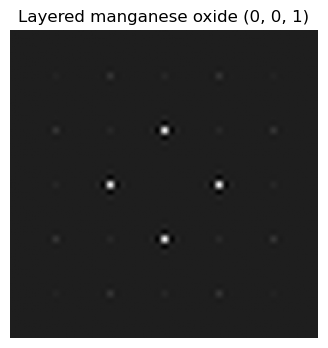

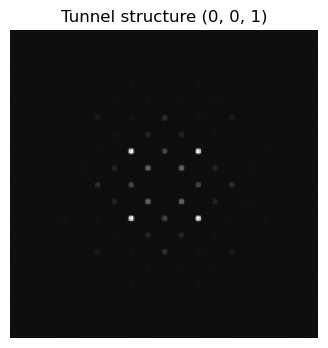

In [11]:
for json_i in result_json:
    crystal = json_i['crystal_geometry']
    zone_axis = crystal['zone_axis']
    zone_axis = tuple(int(ch) for ch in zone_axis.strip("[]"))
    phases = json_i['possible_phases']
    for phase in phases:
        cif_string = phase['cif_description']
        print(phase["structure_type"] + ' ' + str(zone_axis) + ', justification: '+ phase['justification'])
        zone_axis = convert_miller_direction(zone_axis)
        I = calc_diffration_pattern(cif_string, zone_axis)
        f,ax = plt.subplots(figsize = (4,4))
        ax.imshow(I,cmap = 'gray')
        ax.set_axis_off()
        ax.set_title(phase["structure_type"] + ' ' + str(zone_axis))

Input:  
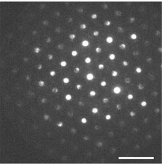  
System info:  
{
    "material_type": "MnO2 nanoparticle",  
    "synthesis_details": "MnO2 particles were prepared by acid leaching of the as-purchased LiMn2O4 particles (Sigma-Aldrich) following the literature method. LiMn2O4 particles (2 g) were soaked in 200 ml 0.1 M HCl aqueous solution (Alfa Aesar) and stirred at 300 r.p.m. overnight to produce delithiated LixMn2O4 particles.",  
    "microscopy_type": "4D-STEM (summed pattern)",  
    "experimental_details": {
        "voltage": "300 kV"
    }
}  
Source: https://www.nature.com/articles/s41563-022-01381-4